<a href="https://colab.research.google.com/github/mhdahime-hadoop/sql/blob/main/ML_lab_week3rd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# install pyspark
!pip3 install pyspark


In [23]:
#initialize SparkSession and installed Required Libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize SparkSession
spark = SparkSession.builder \
                    .appName("LinearRegression_spark") \
                    .master("local[*]") \
                    .config("spark.executor.memory", "4g") \
                    .config("spark.driver.memory", "2g") \
                    .config("spark.executor.cores", "2") \
                    .config("spark.sql.inMemoryColumnarStorage.compressed", "true") \
                    .getOrCreate()


spark

In [24]:
print(f"Spark UI available at: {spark.sparkContext.uiWebUrl}")

Spark UI available at: http://39bb69237f3e:4040


In [25]:
spark.sparkContext.setLogLevel("INFO")

In [26]:
import psutil
print(f"CPU Usage: {psutil.cpu_percent()}%")
print(f"Memory Usage: {psutil.virtual_memory().percent}%")

CPU Usage: 17.9%
Memory Usage: 16.3%


In [41]:
# Load the data from a CSV file
df = spark.read.csv("/content/Diabetes.csv", header=True, inferSchema=True)

# get familiar with data
df.show()

# more info
print("Total Records",df.count())
print("Total Partitions ",df.rdd.getNumPartitions())

+---+---+------+-----+------+------+-----+-----+----+-----+------+-----------+
| id|age|   sex|  bmi|    bp|    tc|  ldl|  hdl| tch|  ltg|   glu|progression|
+---+---+------+-----+------+------+-----+-----+----+-----+------+-----------+
|  0| 22|  Male|20.33|106.25|140.89|-0.45|62.83|0.77|-0.54|130.98|      29.83|
|  1| 41|Female|25.99|132.23|129.64|-1.11|37.26|0.81| 1.64|151.19|      46.66|
|  2| 51|Female|32.76| 127.0|220.36|-1.69|49.56|0.41|-0.88|176.22|      59.97|
|  3| 26|  Male|35.87| 138.4|194.19|-0.04|55.57|0.45|-1.38|125.32|      42.44|
|  4| 42|Female| 21.5|122.33|275.79| 1.19|63.64|0.54|-0.69|184.72|      49.36|
|  5| 47|  Male|31.62|137.18|232.35|-1.65|36.68|0.26| 1.63| 99.83|      54.15|
|  6| 22|  Male|37.06|106.47|244.34|-0.07|34.22|0.48|-1.72| 65.41|      39.55|
|  7| 23|  Male|26.75|129.39|177.69|-0.37|42.03|0.68| 0.82|180.71|      33.12|
|  8| 44|Female|28.38|125.23|276.99| 0.69|55.18| 1.1|-0.52|134.71|      53.84|
|  9| 36|  Male|36.83| 121.9|174.81|  1.1|53.55|0.25

In [42]:
# check missing or null values for each column
from pyspark.sql.functions import col,isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c))
.alias(c) for c in df.columns]).show()

+---+---+---+---+---+---+---+---+---+---+---+-----------+
| id|age|sex|bmi| bp| tc|ldl|hdl|tch|ltg|glu|progression|
+---+---+---+---+---+---+---+---+---+---+---+-----------+
|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|          0|
+---+---+---+---+---+---+---+---+---+---+---+-----------+



In [43]:
# convert categorical column into numbers
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol = 'sex', outputCol = 'gender')
#df = indexer.fit(df).transform(df)
df.show(30)

+---+---+------+-----+------+------+-----+-----+----+-----+------+-----------+
| id|age|   sex|  bmi|    bp|    tc|  ldl|  hdl| tch|  ltg|   glu|progression|
+---+---+------+-----+------+------+-----+-----+----+-----+------+-----------+
|  0| 22|  Male|20.33|106.25|140.89|-0.45|62.83|0.77|-0.54|130.98|      29.83|
|  1| 41|Female|25.99|132.23|129.64|-1.11|37.26|0.81| 1.64|151.19|      46.66|
|  2| 51|Female|32.76| 127.0|220.36|-1.69|49.56|0.41|-0.88|176.22|      59.97|
|  3| 26|  Male|35.87| 138.4|194.19|-0.04|55.57|0.45|-1.38|125.32|      42.44|
|  4| 42|Female| 21.5|122.33|275.79| 1.19|63.64|0.54|-0.69|184.72|      49.36|
|  5| 47|  Male|31.62|137.18|232.35|-1.65|36.68|0.26| 1.63| 99.83|      54.15|
|  6| 22|  Male|37.06|106.47|244.34|-0.07|34.22|0.48|-1.72| 65.41|      39.55|
|  7| 23|  Male|26.75|129.39|177.69|-0.37|42.03|0.68| 0.82|180.71|      33.12|
|  8| 44|Female|28.38|125.23|276.99| 0.69|55.18| 1.1|-0.52|134.71|      53.84|
|  9| 36|  Male|36.83| 121.9|174.81|  1.1|53.55|0.25

In [44]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols = ["age", "gender", "bmi","bp","tc","ldl","hdl","tch","ltg","glu"],
                           outputCol = "Features")

In [45]:
#StandardScaler
scaler = StandardScaler(inputCol = "Features",
                        outputCol = "scaled_Features")

In [46]:
#create linear regression model.
regressor = LinearRegression(labelCol = 'progression',
                             featuresCol = 'scaled_Features'
                             )

In [47]:
from pyspark.ml import Pipeline
pipeline  = Pipeline(stages = [indexer,assembler,scaler,regressor])
#--Saving the Pipeline
pipeline.write().overwrite().save("pipeline_LRsaved_model")

In [48]:
#Loading the Pipeline

pipelineModel = Pipeline.load('./pipeline_LRsaved_model')

In [49]:
data_train , data_test = df.randomSplit([0.7,0.3], seed = 123)

In [50]:
Model = pipeline.fit(data_train)

In [52]:
print("total LR cofficents",len(Model.stages[3].coefficients) )
print("Cofficientents",Model.stages[3].coefficients)
print("Intecept",Model.stages[3].intercept)

total LR cofficents 10
Cofficientents [8.502430305819548,5.10009914113886e-06,3.498183838107447,0.09996892814257681,-1.7903153082759166e-06,1.0011710635500504,-6.082063659106147e-07,-0.019992637345280444,-0.800332798473984,-3.432551272439523e-07]
Intecept 6.616544268198269e-05


In [53]:
#n the prediction phase, we test our model on some unseen data.
pred = Model.transform(data_test)
pred.select('prediction', 'progression').show(10, truncate = False)

+------------------+-----------+
|prediction        |progression|
+------------------+-----------+
|59.97303581221206 |59.97      |
|39.55272591129682 |39.55      |
|51.80502594481944 |51.81      |
|60.75132257419162 |60.75      |
|41.1119433951038  |41.11      |
|52.23422238261993 |52.23      |
|47.077329428433295|47.08      |
|29.530124879915338|29.53      |
|58.812434571858155|58.81      |
|55.61782088599335 |55.62      |
+------------------+-----------+
only showing top 10 rows



In [55]:
Lasoregressor = LinearRegression(labelCol = 'progression',
                             featuresCol = 'scaled_Features',
                             elasticNetParam=1,
                             regParam=0.1
                             )
Lasaopipeline  = Pipeline(stages = [indexer,assembler,scaler,Lasoregressor])
LassoModel = Lasaopipeline.fit(data_train)

In [56]:
#n the prediction phase, we test our model on some unseen data.
lassopred = LassoModel.transform(data_test)
lassopred.select('prediction', 'progression').show(10, truncate = False)

+------------------+-----------+
|prediction        |progression|
+------------------+-----------+
|59.82024800507177 |59.97      |
|39.5950102503772  |39.55      |
|51.527013101779445|51.81      |
|60.64909540434233 |60.75      |
|41.544535986452445|41.11      |
|52.38059086977664 |52.23      |
|47.092984586937156|47.08      |
|29.482487288220593|29.53      |
|58.49573484236181 |58.81      |
|55.56966410771524 |55.62      |
+------------------+-----------+
only showing top 10 rows



In [58]:
#create linear regression model.
Ridgeregressor = LinearRegression(labelCol = 'progression',
                             featuresCol = 'scaled_Features',
                             elasticNetParam=0,
                             regParam=0.1
                             )
Ridgepipeline  = Pipeline(stages = [indexer,assembler,scaler,Ridgeregressor])
RidgeModel = Ridgepipeline.fit(data_train)

In [60]:
Ridgepred = RidgeModel.transform(data_test)
Ridgepred.select('prediction', 'progression').show(10, truncate = False)

+------------------+-----------+
|prediction        |progression|
+------------------+-----------+
|59.86358566750655 |59.97      |
|39.66084381490999 |39.55      |
|51.7829546940159  |51.81      |
|60.63407347623129 |60.75      |
|41.20361501549629 |41.11      |
|52.20764403526073 |52.23      |
|47.105649549790435|47.08      |
|29.74574086678449 |29.53      |
|58.71561078991803 |58.81      |
|55.55563495854291 |55.62      |
+------------------+-----------+
only showing top 10 rows



In [62]:
#Model Evaluation Spark Provides evaluation metrics
#for regression and classification tasks.
from pyspark.ml.evaluation import RegressionEvaluator
evaluator_mse = RegressionEvaluator(labelCol =
                                    'progression',
                                    predictionCol =
                                    'prediction',
                                    metricName =
                                    'mse')
# calculate MSE
mse1 = evaluator_mse.evaluate(pred)
mselasso = evaluator_mse.evaluate(lassopred)
mseridge = evaluator_mse.evaluate(Ridgepred )

evaluator_rmse = RegressionEvaluator(labelCol =
                                     'progression',
                                     predictionCol =
                                     'prediction',
                                     metricName =
                                     'rmse')
# calculate RMSE
rmse1 = evaluator_rmse.evaluate(pred)
rmse2_lasso = evaluator_rmse.evaluate(lassopred)
rmse3Ridge = evaluator_rmse.evaluate(Ridgepred)

evaluator_r2 = RegressionEvaluator(labelCol = 'progression',
                                   predictionCol = 'prediction',
                                   metricName = 'r2')
# calculate R_squared
r2_score1 = evaluator_r2.evaluate(pred)
r2_lasso = evaluator_r2.evaluate(lassopred)
r2_ridge = evaluator_r2.evaluate(Ridgepred)
# print the evaluation metrics
print('Regression - MSE: ', mse1, ', RMSE: ', rmse1, ', R^2: ', r2_score1)
print('Lasso - MSE: ', mselasso, ', RMSE: ', rmse2_lasso, ', R^2: ', r2_lasso)
print('Ridge - MSE: ', mseridge, ', RMSE: ', rmse3Ridge, ', R^2: ', r2_ridge)

Regression - MSE:  8.342275025192193e-06 , RMSE:  0.0028882996771789787 , R^2:  0.999999903251253
Lasso - MSE:  0.05035116477252246 , RMSE:  0.22439065215049056 , R^2:  0.9994160571205042
Ridge - MSE:  0.009817465369110429 , RMSE:  0.09908312353327599 , R^2:  0.9998861428723071


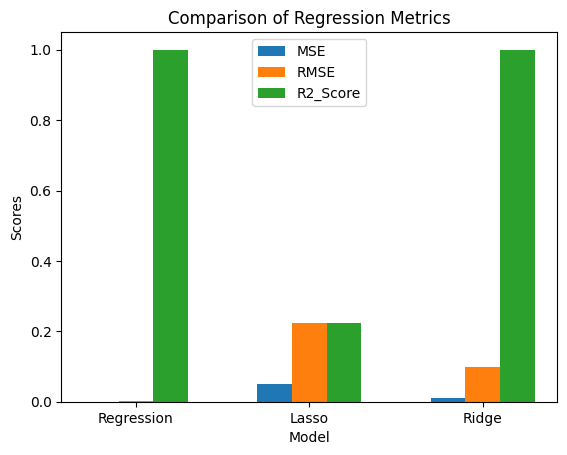

In [63]:
# plot
import matplotlib.pyplot as plt
import numpy as np

mse = [mse1, mselasso, mseridge]
rmse = [rmse1, rmse2_lasso, rmse3Ridge]
r2_score = [r2_score1, rmse2_lasso, r2_ridge]

positions = np.arange(len(mse))
bar_width = 0.2

plt.bar(positions - bar_width, mse, width = bar_width, label = 'MSE')
plt.bar(positions, rmse, width = bar_width, label = 'RMSE')
plt.bar(positions + bar_width, r2_score, width = bar_width, label = 'R2_Score')

# adding labels and title
plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Comparison of Regression Metrics')

# adding the legend
plt.legend()
plt.xticks(positions, ['Regression', 'Lasso', 'Ridge'])
plt.show()